In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




---



## ⚓ **Basic Pre-Requisite** ⚓

**Tensors:** In simple words, its just an n-dimensional array in PyTorch. Tensors support some additional enhancements which make them unique: Apart from CPU, they can be loaded or the GPU for faster computations. On setting .requires_grad = True they start forming a backward graph that tracks every operation applied on them to calculate the gradients using something called a dynamic computation graph




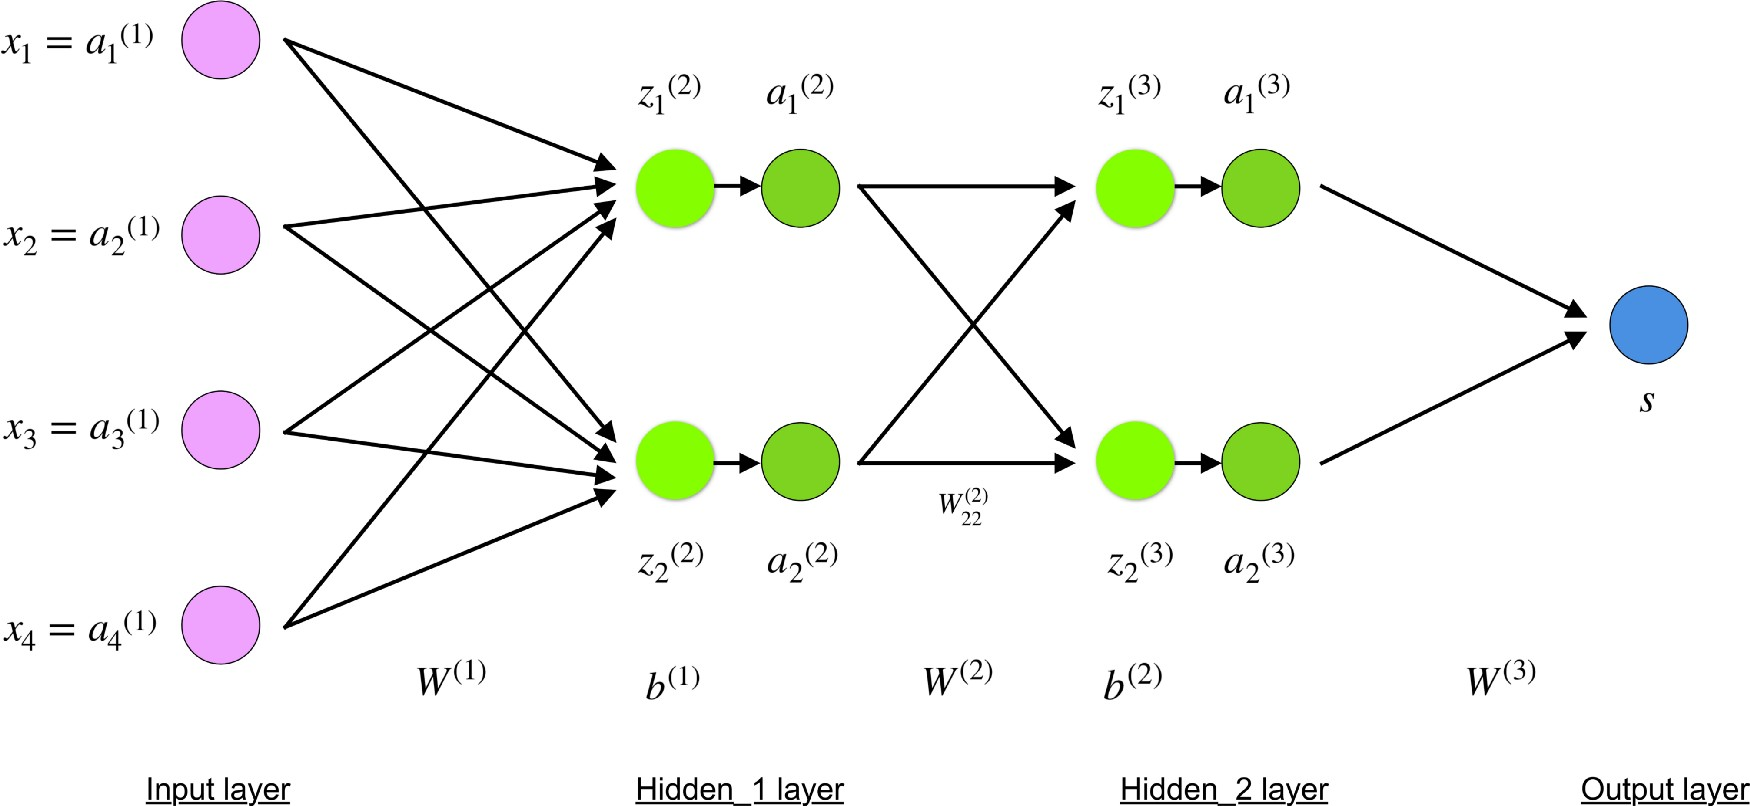



---



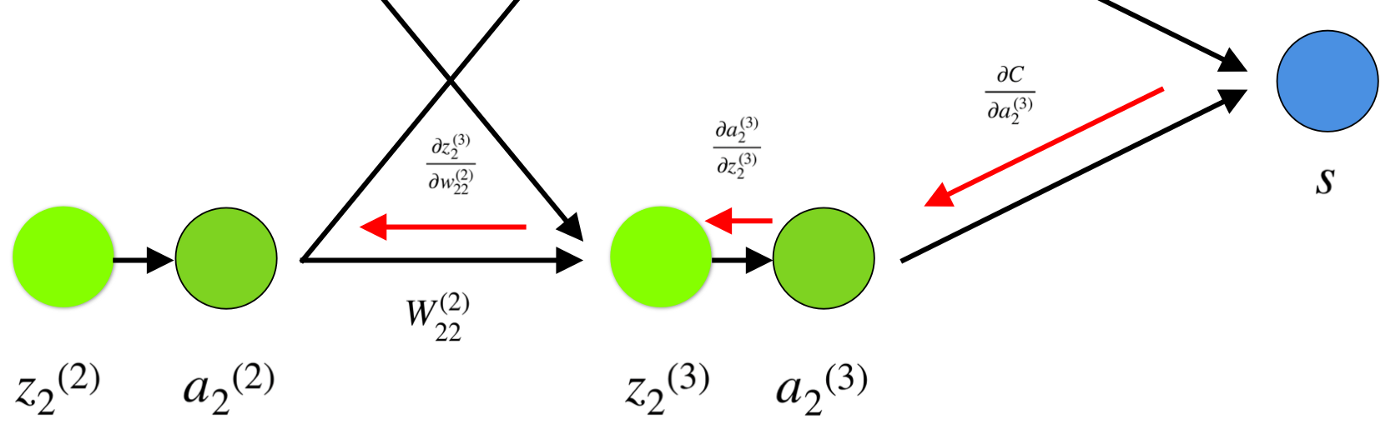

Weight (w_22)² connects (a_2)² and (z_2)², so computing the gradient requires applying the chain rule through (z_2)³ and (a_2)³:

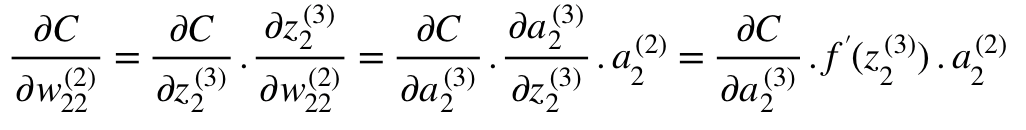

A simple DCG for multiplication of two tensors would look like this:

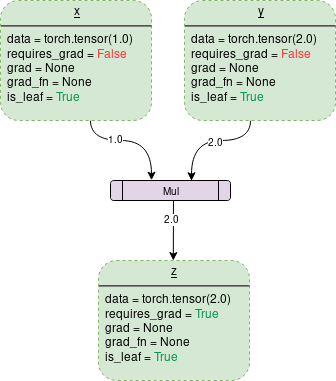

Creating and training a neural network involves the following essential steps:
* Define the architecture
* Forward propagate on the architecture using input data
* Calculate the loss
* Backpropagate to calculate the gradient for each weight
* Update the weights using a learning rate

Each dotted outline box in the graph is a variable and the purple rectangular box is an operation.

Every variable object has several members some of which are:

* Data: It’s the data a variable is holding. x holds a 1x1 tensor with the value equal to 1.0 while y holds 2.0. z holds the product of two i.e. 2.0
* requires_grad: This member, if true starts tracking all the operation history and forms a backward graph for gradient calculation. For an arbitrary tensor a It can be manipulated in-place as follows: a.requires_grad_(True).
* grad: grad holds the value of gradient. If requires_grad is False it will hold a None value. Even if requires_grad is True, it will hold a None value unless .backward() function is called from some other node. For example, if you call out.backward() for some variable out that involved x in its calculations then x.grad will hold ∂out/∂x.
* grad_fn: This is the backward function used to calculate the gradient.
* is_leaf: A node is leaf if :
  * It was initialized explicitly by some function like x = torch.tensor(1.0) or x = torch.randn(1, 1) (basically all the tensor initializing methods discussed at the beginning of this post).
  * It is created after operations on tensors which all have requires_grad = False.
  * It is created by calling .detach() method on some tensor.

On calling backward(), gradients are populated only for the nodes which have both requires_grad and is_leaf True. Gradients are of the output node from which .backward() is called, w.r.t other leaf nodes.
On turning requires_grad = True PyTorch will start tracking the operation and store the gradient functions at each step as follows:



---



## ⚓ Importing the libraries ⚓



* **%matplotlib inline** sets the backend of matplotlib to the 'inline' backend: With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

* We use **%config InlineBackend. figure_format = 'retina'** after %matplotlib inline - to render higher resolution images.

### Extra info
As of 2018, Torch is no longer in active development. However PyTorch, which is based on the Torch library, is actively developed as of June 2021.

In [ ]:
import os
# loads the OS 

import time
#uses time

from PIL import Image
# use to manipulate images

#from pdb import set_trace as bp 
# can be used for putting up a break point while debugging

#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import numpy as np
# used to manipulate arrays

import torch
# Deep Learning applications using GPUs and CPUs.

from torch.utils import data
from torch import nn
# module to help us in creating and training of the neural network

from torch import optim
# package implementing various optimization algorithms

import torch.nn.functional as F
# Used to apply Convolution functions etc
# https://pytorch.org/docs/stable/nn.functional.html

from torchvision import datasets, transforms, models

import sys



---



## ⚓ Created a Customized Dataset ⚓

**INPUT**: We are taking just the image Root folder as input

In the **init function**, we are defining the 

  * Transforms in which we are resizing all the images to (224,224), then converting it to tensor & then applying normaization 

In [ ]:
class CustomizedClassificationPyTorchDataset(data.Dataset):
    def __init__(
        self,
        imageFolderRoot,
        img_size=(224,224),
        mean= [0.485, 0.456, 0.406],
        std= [0.229, 0.224, 0.225]
    ):
        self.img_size = img_size
        self.transforms = transforms.Compose([transforms.Resize(img_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std)
                ])
        
        self.files = []
        self.lbls = []

        #just reading the sub dirs in imageFolderRoot i.e buildings, sea
        labels =os.listdir(imageFolderRoot)

        lbls_indices = dict()

        for index, label in enumerate(labels):
            lbls_indices[label] = index
            
        print("labels :",labels)
        print("lbls_indices dictionary :",lbls_indices)

        for label in labels:    
            images = os.listdir(os.path.join(imageFolderRoot, label))
            for img in images:
                self.files.append(os.path.join(imageFolderRoot,label,img))
                self.lbls.append(lbls_indices[label])
    
    
    #__getitem__() is a magic method in Python, which when used in a class, allows its instances to use the [] (indexer) operators.     
    def __getitem__(self, index):

        img = self.files[index]
        lbl = self.lbls[index]
        img = Image.open(img).convert('RGB') 
        img = img.resize(self.img_size)
        img = self.transforms(img)
        return img, lbl
    
    # used to find the length of the instance attributes
    # When we invoke the len() method the length of the list named item is 
    # returned that is defined inside the __len__ method.
    def __len__(self):
        return len(self.files)




---



## ⚓ Image Directory paths ⚓

In [ ]:
#FOR VS CODE

#transformname=input("enter the transformname : ")
#PyTorch expects the data to be organized by folders with one folder for each class.
#sys.stdout = open("/mc2/SaiAbhishek/Sprint62/STUDCL-9999-Evaluate improve-Model-performance/AccuracyLogs/"+transformname+"Log.txt", 'w+')

# ===========================================================================

# FOR COLAB
sys.stdout = open('/content/drive/MyDrive/AccuracyLogs/balanced.txt', 'w+')

# for augmented dataset log
# print("===========================================================================")
# print("                               ACCURACY LOG                                ")
# print("===========================================================================")
# print()
# #print("Result for the Augmentation Name :",transformname[3:])[only for augmented datasets]
# print()
# print( "Model used for Training : RESNET18" )
# print()
# print("Dataset Name : Intel Scenery")
# print()
# print("Classes : buildings , sea ")
# print()
# #print("Minority Class upon which augmentation was applied :",transformname[:3]) [only for augmented datasets]
# print()
# print( "Developer Name : Allena Venkata Sai Abhishek")
# print()
# print("===========================================================================")
# print()


# for balanced dataset log

print("===========================================================================")
print("                               ACCURACY LOG                                ")
print("===========================================================================")
print()
print("Result for the Dataset Name : Balanced Dataset")
print()
print( "Model used for Training : RESNET18" )
print()
print("Dataset Name : Intel Scenery")
print()
print("Classes : buildings , sea ")
print()
print( "Developer Name : Allena Venkata Sai Abhishek")
print()
print("===========================================================================")
print()


# For VS CODE
# train datset
#traindatadir = "/mc2/SaiAbhishek/Sprint62/STUDCL-9999-Evaluate improve-Model-performance/AugmentedDataset/"+transformname+"/train"

# fixed test dataset

#testdatadir = "/mc2/SaiAbhishek/Sprint62/STUDCL-9999-Evaluate improve-Model-performance/StaticTestSet/test"

#For COLAB

# train datset
traindatadir = "/content/drive/MyDrive/Datasets/IntelScenery2Classes/balancedDataset/train"

# fixed test dataset

testdatadir = "/content/drive/MyDrive/Datasets/IntelScenery2Classes/StaticTestSet/test"



---



## ⚓ A function to load the data using Dataloader ⚓
( Dataloader combines a dataset and a sampler, and provides an iterable over the given dataset.)

In [ ]:
def load_train_test(traindatadir,testdatadir):
    
    print("For train_dataset")
    train_data = CustomizedClassificationPyTorchDataset(traindatadir)        

    print("===============================")

    print("For test_dataset")
    test_data = CustomizedClassificationPyTorchDataset(testdatadir) 
    
    print("===============================")

    num_train = len(train_data)
    print("Total number of images in train dataset :",num_train)
    
    num_test = len(test_data)
    print("Total number of images in test dataset :",num_test)

    trainloader = torch.utils.data.DataLoader(train_data,
                    batch_size=64,shuffle=True)
    testloader = torch.utils.data.DataLoader(test_data,
                    batch_size=64,shuffle=True)
    
    return trainloader, testloader

In [ ]:
trainloader, testloader = load_train_test(traindatadir,testdatadir)



---



## ⚓ CUDA -Compute Unified Device Architecture ⚓
* CUDA is a parallel computing platform developed by NVIDIA and introduced in 2006. 
* It enables software programs to perform calculations using both the CPU and GPU.

In [ ]:

# using CUDA
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("device used :",device)


# ⚓ ResNet-18 model ⚓
"Deep Residual Learning for Image Recognition" 

In order to solve the problem of the vanishing/exploding gradient and Degradation problem, this architecture introduced the concept called Residual Network. In this network we use a technique called skip connections . The skip connection skips training from a few layers and connects directly to the output.




    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr


`### A brief about -

* ####  **Vanishing Gradient Problem:**

   **Problem** -

  As more layers using certain activation functions are added to neural networks, the gradients of the loss function approaches zero, making the network hard to train.
  
  **Why** - 

  Certain activation functions, like the sigmoid function, squishes a large input space into a small input space between 0 and 1. Therefore, a large change in the input of the sigmoid function will cause a small change in the output. Hence, the derivative becomes small.

  However, when n hidden layers use an activation like the sigmoid function, n small derivatives are multiplied together. Thus, the gradient decreases exponentially as we propagate down to the initial layers.

    **How to know the model has these problem?**
  * The model will improve very slowly during the training phase and it is also possible that training stops very early, meaning that any further training does not improve the model.

  * The weights closer to the output layer of the model would witness more of a change whereas the layers that occur closer to the input layer would not change much (if at all).
  * Model weights shrink exponentially and become very small when training the model.
  * The model weights become 0 in the training phase.


* ####  **Exploding Gradient Problem:**
  In a network of n hidden layers, n derivatives will be multiplied together. If the derivatives are large then the gradient will increase exponentially as we propagate down the model until they eventually explode, and this is what we call the problem of exploding gradient.

  **How to know the model has these problem?**
    * The model is not learning much on the training data therefore resulting in a poor loss.

  * The model will have large changes in loss on each update due to the models instability.

  * The models loss will be NaN during training.

  * Model weights grow exponentially and become very large when training the model.

  * The model weights become NaN in the training phase.

  * The derivatives are constantly

 ### **Solution** -
  
  * ReLU - which doesn’t cause a small derivative.

  * Reducing the amount of Layers

  * Gradient Clipping - If the gradient gets too large, we rescale it to keep it small. More precisely, if ‖g‖ ≥ c
  
    **c . g/‖g‖**

    where c is a hyperparameter, g is the gradient, and ‖g‖ is the norm of g. Since g/‖g‖ is a unit vector, after rescaling the new g will have norm c. Note that if ‖g‖ < c, then we don’t need to do anything.

  * Residual networks - as they provide residual connections straight to earlier layers. 
  
    As seen in Image above, the residual connection directly adds the value at the beginning of the block, x, to the end of the block (F(x)+x). 
    
    This residual connection doesn’t go through activation functions that “squashes” the derivatives, resulting in a higher overall derivative of the block.
  


---



* ####  **Degradation Problem:**
If a “shallow” model is able to achieve an accuracy, then their deeper counterparts should at least have the same accuracy. 

  But, when the model gets deeper, it becomes more and more difficult for the layers to propagate the information from shallow layers and the information is lost. This is called Degradation Problem.



## Resnet Architecture

#### Residual Learning - 

* Let g(x) be the function learned by the layers. Let’s consider h(x) = g(x)+x, layers with skip connections. Here +x term denotes the skip connection.

  In h(x)=g(x)+x, the +x term will bring the original value, layer g(x) has to learn just the changes in the value, or the residue or delta x. 
    
    Whatever being learned in g(x) is just the residue, either positive or negative to modify x to required value. Hence the name “Residual Learning”.

    For h(x) to be identity function, the residue g(x) just has to become zero function, which is very easy to learn, i.e. set all weights to zero. Then h(x) = 0+x = x, which is the required identity function. **This will help overcome the degradation problem.**

#### Skip connection

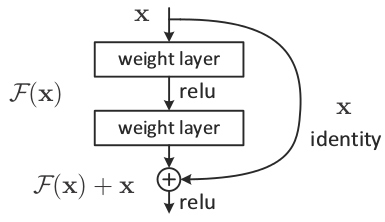

**Why is the relu applied after adding the skip connection?**

* If we had performed relu before addition, then the residues will all be positives or zero. Only positive increments to the identity are learnt, which significantly reduces the learning capacity. 

* For example in the sin function, sin(3π/2) = -1, which would need negative residue. 

* Similarly, using sigmoid will also be disadvantageous, because it produces residues only within 0 to 1. 

* Ideally, we would like unconstrained response from weight layer (spanning any numerical range), to be added to skip layer, then apply activation to provide non-linearity. This helps the model learn any function.


**Why are there two weight layers in one residual block?**


* if we had used a single weight layer, adding skip connection before relu, gives F(x) = Wx+x, which is a simple linear function. 

* This is equivalent to just a single weight layer and there is no point in adding skip connection. 

* So we need at least one non-linearity before adding skip connection, which is achieved by using two layers.

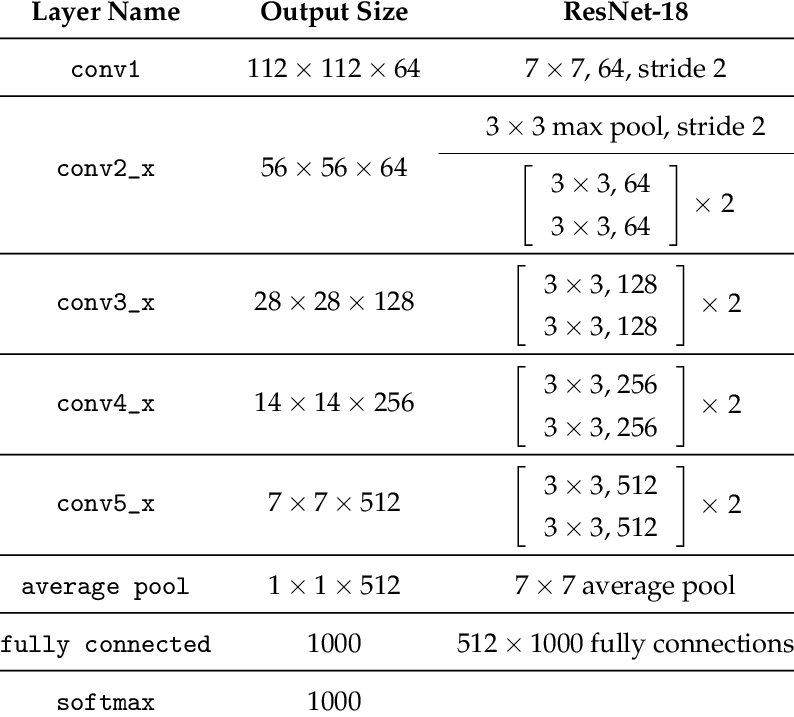



---



## Batch Normalization


Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

### Batch Normalization 2d
Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs with additional channel dimension) as described in the paper Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift .

For more details - https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html

Parameters

    num_features – CC from an expected input of size (N, C, H, W)(N,C,H,W)

    eps – a value added to the denominator for numerical stability. Default: 1e-5

    momentum – the value used for the running_mean and running_var computation. Can be set to None for cumulative moving average (i.e. simple average). Default: 0.1

    affine – a boolean value that when set to True, this module has learnable affine parameters. Default: True

    affine is True means - With Learnable Parameters
    affine is False means - Without Learnable Parameters

    track_running_stats – a boolean value that when set to True, this module tracks the running mean and variance, and when set to False, this module does not track such statistics, and initializes statistics buffers running_mean and running_var as None. When these buffers are None, this module always uses batch statistics. in both training and eval modes. Default: True

Shape:

    Input: (N, C, H, W)(N,C,H,W)

    Output: (N, C, H, W)(N,C,H,W) (same shape as input)



---



## ⚓ Define the model ⚓

In [ ]:
  
model = models.resnet18(pretrained=False)
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

PyTorch Loss-Input Confusion (Cheatsheet)

* torch.nn.functional.binary_cross_entropy takes logistic sigmoid values as inputs
* torch.nn.functional.binary_cross_entropy_with_logits takes logits as inputs
* torch.nn.functional.cross_entropy takes logits as inputs (performs log_softmax internally)
* torch.nn.functional.nll_loss is like cross_entropy but takes log-probabilities (log-softmax) values as inputs


REFER - https://github.com/rasbt/stat479-deep-learning-ss19/blob/master/other/pytorch-lossfunc-cheatsheet.md

A Logit function, also known as the log-odds function, is a function that represents probability values from 0 to 1, and negative infinity to infinity. The function is an inverse to the sigmoid function that limits values between 0 and 1 across the Y-axis, rather than the X-axis.



---



## ⚓ Add a sequential layer to Resnet ⚓

In [ ]:
for param in model.parameters():
    # Here, the returned param is torch.nn.Parameter class which is a tensor.
    # Since param is a type of tensor, it has shape and requires_grad attributes too.
    
    param.requires_grad = False
    # param.requires_grad is a boolean which tells if the parameter is learnable or not.

# If we want the whole network to change weights, 
# then we should remove that for loop, where we are setting params.requires_grad = False. 
# But its not a good idea as the number of samples are too less compared 
# to the number of weights. so, its advised to freeze all the layers except fc

# we are setting them false for the pretrained weights. 
# For the last fc layer that we created based on the number of classes, 
# the grads are being calculated, so training has no issue.



# The forward() method of Sequential accepts any
# input and forwards it to the first module it contains. It then
# "chains" outputs to inputs sequentially for each subsequent module,
# finally returning the output of the last module.

model.fc = nn.Sequential(nn.Linear(512, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 2),
                                 nn.LogSoftmax(dim=1))

# Using Sequential to create a model. When `model` is run,
# input will first be passed to `Linear(512, 512)`. The output of
# `Linear(512, 512)` will be used as the input to the first
# `ReLU`; the output of the first `ReLU` will become the input
# for `Dropout(0.2)`. the output of the first `Dropout(0.2)` will 
# become the input for `Linear(512, 2)`.Finally, the output of
# `Linear(512, 2)` will be used as input to the second `LogSoftmax`



---



## ⚓ Loss function ⚓

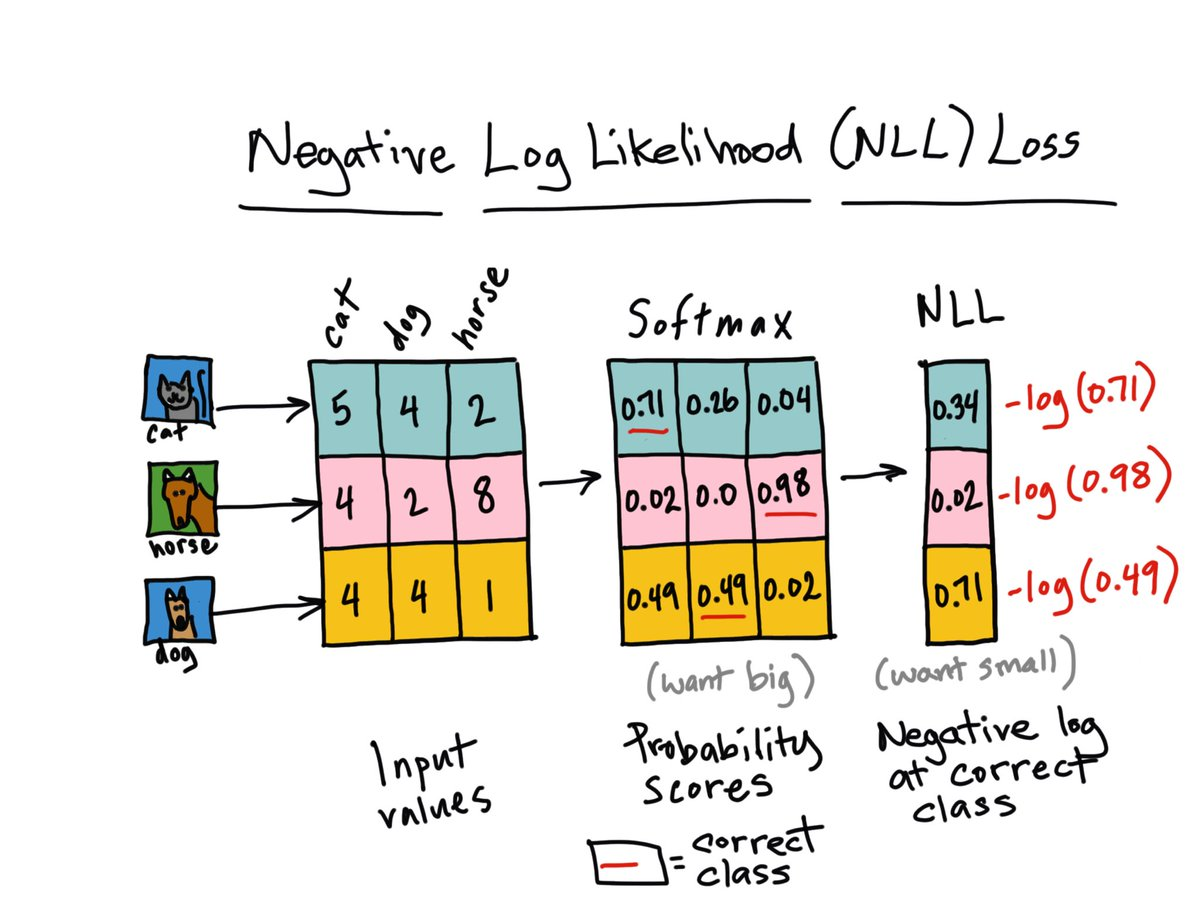

In [ ]:
criterion = nn.NLLLoss()
#  Loss functions define what a good prediction is and isn't.
# a way to measure how well the model is performing.

optimizer = optim.Adam(model.fc.parameters(), lr=0.0003)
# Optimizers are algorithms or methods used to change the attributes of the neural network 
# such as weights and learning rate to reduce the losses.

model.to(device)
# now u can also see the last sequential layer that I have added to the Resnet model
# inorder to use get the probabilities which can be used to calculate the accuracies

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  



---


## ⚓ Adam Optimizer ⚓ 
*Stochastic gradient* descent maintains a single learning rate (termed alpha) for all weight updates and the learning rate does not change during training.

A **learning rate** is maintained for each network weight (parameter) and separately adapted as learning unfolds.

**Adam as combining the advantages of two other extensions of stochastic gradient descent. Specifically:**

* **Adaptive Gradient Algorithm (AdaGrad)** that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).
* **Root Mean Square Propagation (RMSProp)** that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).

Instead of adapting the parameter learning rates based on the average first moment (the mean) as in RMSProp, Adam also makes use of the average of the second moments of the gradients (the uncentered variance).

Specifically, the algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.

The initial value of the moving averages and beta1 and beta2 values close to 1.0 (recommended) result in a bias of moment estimates towards zero. This bias is overcome by first calculating the biased estimates before then calculating bias-corrected estimates.

* ### Adam is a popular algorithm in the field of deep learning because it achieves good results fast



---


## ⚓ Training & Testing ⚓ 

In [ ]:

since = time.time()

epochs = 10
running_loss = 0.0

train_accuracy_list = []

correct_predictions=0
total_labels = 0

for epoch in range(epochs):

    model.train()

    for inputs, labels in trainloader:
        
        #=============================

        # augmented_imgs=fun(inputs) 
        # augmented_lbls=fun(inputs,labels)

        # inputs.extend(augmented_imgs)
        # lbls.extend(augmented_lbls)

        #=============================

        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients (clearing optimizer)
        optimizer.zero_grad()
        
        logps = model.forward(inputs)

        # logps - log probabilities
        loss = criterion(logps, labels)

        # backward + optimize only if in training phase
        loss.backward()
        optimizer.step()
        #The loss function is the function that computes the distance between the current output of the algorithm and the expected output.
        running_loss += loss.item()

        probs = torch.exp(logps)
        probs=probs.cpu()

        pred_labels = np.argmax(probs.detach().numpy(), axis=1)

        labels=labels.cpu()
        correct_predictions += np.sum(labels.detach().numpy() ==pred_labels)
        total_labels += len(labels)
        epoch_loss=running_loss/len(trainloader)
    Train_accuracy = correct_predictions/total_labels
    train_accuracy_list.append(Train_accuracy)
    print(f" Training Phase : Epoch {epoch+1}/{epochs}..Train loss: {epoch_loss}.. Train accuracy: { Train_accuracy}")

print("The Final Train Loss :",epoch_loss)
print("The Final Train Accuracy :",Train_accuracy)
print("The Best Train Accuracy :",max(train_accuracy_list))

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# ============================================== TRAINING DONE =============================================

correct_predictions = 0
model.eval()
total_labels = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        probs = torch.exp(logps)
        probs=probs.cpu()
        pred_labels = np.argmax(probs.detach().numpy(), axis=1)
        labels=labels.cpu()
        correct_predictions += np.sum(labels.detach().numpy() ==pred_labels)
        total_labels += len(labels)

                
Testaccuracy = correct_predictions/total_labels
print("Test Accuracy :",Testaccuracy)


sys.stdout.close()            

# ============================================== TESTING DONE =============================================




---


# 😃 ⚛ Thank you ⚛ 😃


---

